<a href="https://colab.research.google.com/github/nickwan/nwds-stream-notebooks/blob/main/bullriding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap --quiet

     |████████████████████████████████| 266kB 3.5MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Why this is a horrible idea
I have no domain knowledge or experience in this field -- limiting my ability to ask quality, informative, testable questions.  

I should probably watch like at least a seasons worth of bull riding but here I am, a domain idiot, doing data science drunk on a Friday, with some randos in stream (hello!)  

I honestly don't even know how you "win" or "gain points" in this sport. Like, at all. Zero clue. (update: i've learned this now)  

# Why this is a great idea  
I have no priors -- zero assumptions or biases as to what is important or not important. I have no rooting interests -- I am a true 3rd party to this sport.  

# Things to do  
* Ingest data  
* Describe data  
* Test empirical correlations and deviations  
* Generate predictive analytics for "points"?  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler,scale

import shap
sns.set_context('talk')
shap.initjs()

In [ ]:
project_dir = "/content/drive/My Drive/bullriding"
df = pd.read_csv(f"{project_dir}/data/outs_tbl.csv",header=None)
df_bull = pd.read_csv(f"{project_dir}/data/bullrank.csv")
df_bull_names = pd.read_csv(f"{project_dir}/data/bulls.csv")
df_bull.columns = df_bull.columns.str.upper()
df_bull = df_bull.rename(columns={'PBID':'BULL_ID',
                        'RANK':'BULL_RANK',
                        'RAWRANK':'BULL_RAWRANK',
                        'ARANK':'BULL_ARANK'})
df_bull = df_bull_names.loc[:,['pbid','bname']].rename(columns={'pbid':'BULL_ID','bname':'BULL_NAME'}).merge(df_bull)

col_names = ['YEAR', 'BULL_ID', 'RODEO_ID', 'PERF', 'CONTESTANT',
 'TOTAL_SCORE', 'JUDGE_A', 'JUDGE_B', 'TIME', 'GO',
 'COMMENTS', 'MID', 'QR', 'IS_OUT']
df.columns = col_names
df['BULL_SCORE'] = df['JUDGE_A'].add(df['JUDGE_B'])
df['RIDER_SCORE'] = df['TOTAL_SCORE'].sub(df['BULL_SCORE']).abs()
df.loc[df['TIME']<8,'RIDER_SCORE'] = 0
df['CONTESTANT_CODE'] = df['CONTESTANT'].astype('category').cat.codes
df['RODEO_LEVEL'] = df['RODEO_ID'].str.replace('[^a-zA-Z]', '').str.upper()

df['RODEO_LEVEL'] = (df['RODEO_LEVEL']
 .replace(['ABG', 'ABH','ABD','ABC', 'ABB', 'ABA',
           'AC', 'AE', 'AH','ABE', 'AN','AZ',
           'ABGC', 'AV'],
          'BB')
 .replace(['C', 'F', 'Q', 'QX', 'XQ','CF',
           'X','B', 'XT', 'O','E'],
          'R'))
df['LEVEL_CODE'] = df['RODEO_LEVEL'].astype('category').cat.codes
df = df.merge(df_bull,how='left')
df.loc[:,df_bull.columns.values] = df.loc[:,df_bull.columns.values].fillna(-1)
df['DIRPREF_CODE'] = df['DIRPREF'].replace('unknown',-1).astype('category').cat.codes

df.shape

(440833, 43)

In [ ]:
stack = pd.read_csv(f"{project_dir}/data/2019_stack.csv")
stack.shape

(8132, 16)

# bull data  
each row is a bull  
`rank`: ranking among all bulls  
`avgmark`: avg bull score  
`adjavg`: adjustment based on level  
`pavg`: PBR avg  
`bavg`: CBR avg ("B" events)  
`mounted`: attempted rides  
`rode`: qualified rides  
`vtg*`: versus the best riders  
`vsr*`: versus right-handed riders  
`vsl*`: versus left-handed riders  
`dirpref`: the estimated preferred direction the bull spins  
`dirperc`: percentage the bull spins in the preferred direction  
`power`: performances + difficulty  
`winperc`: percentage of the time they are the highest marked bull in the round  
`rawrank`: temp column based on rank   
`arank`: rank among active bulls  

## column info from slade tha gawd  
`YEAR`: year duh  
`BULL_ID`: the bull that is being ridden  
`RODEO_ID`: the rodeo  
`PERF`: performance (event)  
`CONTESTANT`: name of rider  
`RIDER_SCORE`: score of the rider based on judges  
`JUDGE_A`: one of two judges, bull score only  
`JUDGE_B`: one of two judges, bull score only  
`TIME`: duration of ride  
`GO`: ???  
`COMMENTS`: ???  
`MID`: match up ID (bull + rider; also row ID)    
`QR`:  qualified ride (1 if scored; 0 if no score)    
`IS_OUT`: is the out legit? (ride oddities, rarities like hurt in the chute, bull falling down, etc)    

# competition levels  
NFR  
AB   
BB (everything that starts with A but isn't AB)  
R (everything else)  


In [ ]:
df.loc[df['TIME']==8].shape

(112097, 43)

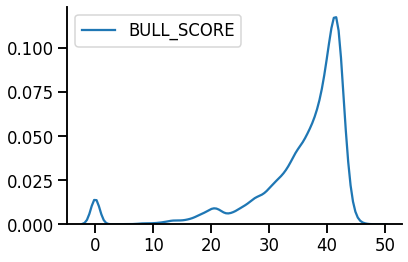

count    43121.000000
mean        35.466990
std          8.771787
min          0.000000
25%         33.000000
50%         38.480769
75%         41.125000
max         48.000000
Name: BULL_SCORE, dtype: float64



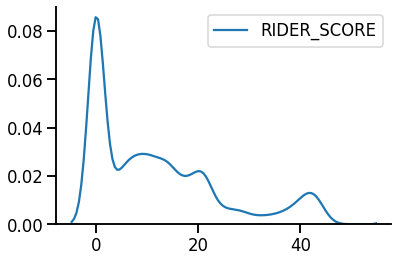

count    43121.000000
mean        11.821331
std         12.764880
min          0.000000
25%          0.000000
50%          8.700000
75%         18.785714
max         50.000000
Name: RIDER_SCORE, dtype: float64



In [ ]:
bull_desc = df.loc[:,['BULL_ID','BULL_SCORE','RIDER_SCORE']].groupby('BULL_ID',as_index=False).mean()
sns.kdeplot(bull_desc['BULL_SCORE'])
sns.despine()
plt.show()
print(bull_desc['BULL_SCORE'].describe())
print()
sns.kdeplot(bull_desc['RIDER_SCORE'])
sns.despine()
plt.show()
print(bull_desc['RIDER_SCORE'].describe())
print()

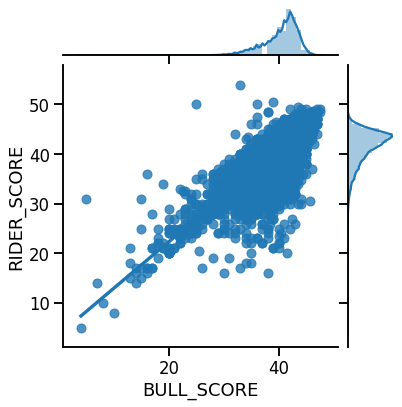

R2: 0.7668819716609137


In [ ]:
sns.jointplot('BULL_SCORE','RIDER_SCORE',data=df.loc[df['TIME']==8].sample(30000),kind='reg')
plt.show()
print(f"R2: {pearsonr(df.loc[df['TIME']==8,'BULL_SCORE'],df.loc[df['TIME']==8,'RIDER_SCORE'])[0]**2}")

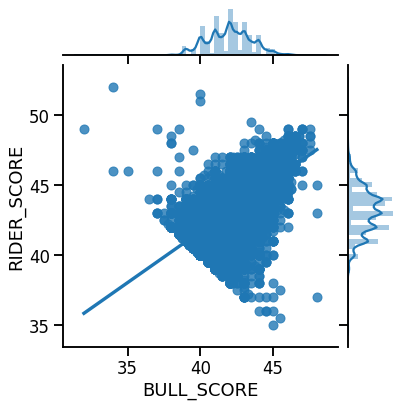

R2: 0.44396373871479067


In [ ]:
sns.jointplot('BULL_SCORE','RIDER_SCORE',data=df.loc[(df['TIME']==8)&(df['TOTAL_SCORE']>=80)].sample(30000),kind='reg')
plt.show()
print(f"R2: {pearsonr(df.loc[(df['TIME']==8)&(df['TOTAL_SCORE']>=80),'BULL_SCORE'],df.loc[(df['TIME']==8)&(df['TOTAL_SCORE']>=80),'RIDER_SCORE'])[0]**2}")

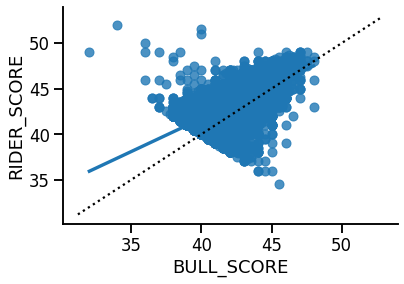

In [ ]:
f = sns.regplot('BULL_SCORE','RIDER_SCORE',data=df.loc[(df['TIME']==8)&(df['TOTAL_SCORE']>=80)].sample(30000))
plt_max = np.max([f.get_xlim(), f.get_ylim()])
plt_min = np.min([f.get_xlim(), f.get_ylim()])
plt.plot([plt_min,plt_max],[plt_min,plt_max],'k:')
sns.despine()
plt.show()

In [ ]:
_counts = df['CONTESTANT'].value_counts()
qual_riders = _counts[_counts>=50].index.values
print(df.loc[df['CONTESTANT'].isin(qual_riders),'QR'].mean())
df.loc[df['CONTESTANT'].isin(['Sage Kimzey','Jess Lockwood']),['CONTESTANT','QR']].groupby('CONTESTANT',as_index=False).mean()
# df.loc[df['CONTESTANT'].isin(['Sage Kimzey','Jess Lockwood'])]



0.2971268641581374


,CONTESTANT,QR
0,Jess Lockwood,0.512702
1,Sage Kimzey,0.615183


If a rider did get eights, what would they have scored? 🤔  

simple model:  
train a GBDT on IDs and target rider score.  

less simple model:  
GBDT but a quantile distribution model  

other models:  
poisson?  

model features:  
YEAR, BULL_ID, CONTESTANT_CODE   

QR mean as a scores vs outs rider metric  

bull's real difficulty using his bull scores  
how hard he is to stay on for 8s  
"if you are a bull rider, you want a bull that scores high but is easy to ride"  


## Predict bull score with bull features  
'YEAR', 'BULL_ID','LEVEL_CODE','TIME','POWER', 'WINPERC','VSRPERC','VSLPERC'

target is 'BULL_SCORE'

In [ ]:
_comm = df['COMMENTS'].value_counts()
_comm[_comm>100]

*               332479
(nt)             34417
TO               12888
DR               10187
(nmb)             6556
(nma)             6130
RR inf            5656
TONN              4518
(nm)              4099
RR foul           3008
RR fell           2489
(nm)(nt)          2461
VI                2153
RR decl           2053
(nma)(nt)         1714
(nmb)(nt)         1599
E!                1598
RR ?              1493
RR chute          1105
RR crip            871
RR stop            470
yuk!               241
RR inf decl        229
OWJI               180
RR no nod          180
E!(nt)             138
RR fell decl       127
RR crip DO         123
Name: COMMENTS, dtype: int64

In [ ]:
model_feats = ['YEAR','LEVEL_CODE','TIME',
               'VSRPERC','VSLPERC']
target = 'BULL_SCORE'
model_data = df.loc[(~df['COMMENTS'].str.contains('(nt)',regex=False).fillna(False))&(df['TIME'].between(2,7.99)), model_feats+['BULL_ID']+[target]]
model_data.sample(5)

,YEAR,LEVEL_CODE,TIME,VSRPERC,VSLPERC,BULL_ID,BULL_SCORE
301131,2013,3,5.72,62.50,80.00,26128,44.5
242438,2010,3,2.53,100.00,100.00,17962,42.5
302090,2013,1,2.23,60.00,33.33,24807,43.5
207859,2010,3,7.90,83.33,100.00,19768,40.0
46401,2004,3,5.80,73.68,62.50,2752,44.0


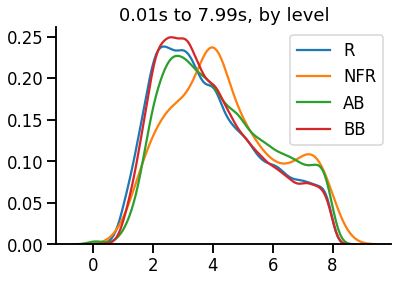

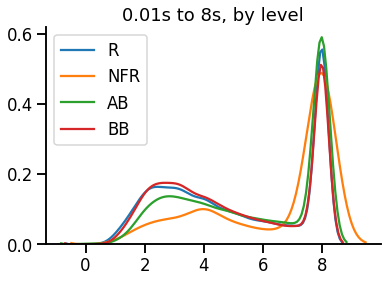

In [ ]:
for level in df['RODEO_LEVEL'].unique():
  sns.kdeplot(df.loc[(~df['COMMENTS'].str.contains('(nt)',regex=False).fillna(False))&(df['RODEO_LEVEL']==level)&(df['TIME'].between(0.01,7.99)),'TIME'],label=level)
sns.despine()
plt.title('0.01s to 7.99s, by level')
plt.show()

for level in df['RODEO_LEVEL'].unique():
  sns.kdeplot(df.loc[(~df['COMMENTS'].str.contains('(nt)',regex=False).fillna(False))&(df['RODEO_LEVEL']==level)&(df['TIME'].between(0.01,8)),'TIME'],label=level)
sns.despine()
plt.title('0.01s to 8s, by level')
plt.show()

In [ ]:
_bulls = model_data['BULL_ID'].drop_duplicates().sample(frac=.2)
test_data = model_data.loc[model_data['BULL_ID'].isin(_bulls.values)]
train_data = model_data.loc[~model_data.index.isin(test_data.index.values)]
print(f"train data: {train_data.shape}\ntest data: {test_data.shape}")

train data: (171733, 7)
test data: (43045, 7)


In [ ]:
lgbm_train = lgb.Dataset(train_data.loc[:,model_feats],
                         train_data.loc[:,target],
                         categorical_feature=['LEVEL_CODE'],
                         free_raw_data=False)

lgbm_test = lgb.Dataset(test_data.loc[:,model_feats],
                        test_data.loc[:,target],
                        categorical_feature=['LEVEL_CODE'],
                        free_raw_data=False)

In [ ]:
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,lgbm_train, num_boost_round=2000, valid_sets=lgbm_test,
                  early_stopping_rounds=200, verbose_eval=False)
test_data['pred'] = pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0]

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


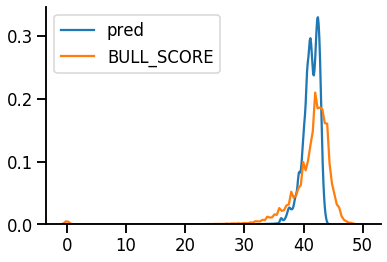

RMSE: 3.865670517761703


In [ ]:
sns.kdeplot(test_data['pred'])
sns.kdeplot(test_data[target])
sns.despine()
plt.show()
print(f"RMSE: {mean_squared_error(test_data[target],test_data['pred'])**0.5}")

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


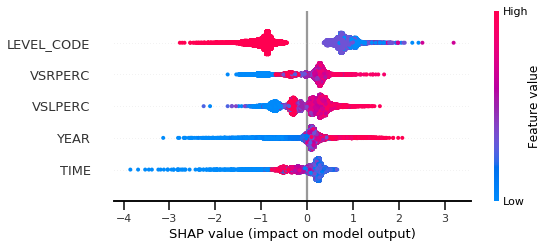

In [ ]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [ ]:
kf = KFold(5)
pred = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  train_data = lgb.Dataset(train_data.loc[:,model_feats],
                           train_data.loc[:,target],
                           categorical_feature=['LEVEL_CODE'],
                           free_raw_data=False)

  test_data = model_data.iloc[test_idx]
  p = dict(objective='regression',boosting='gbdt', metric='rmse')
  model = lgb.train(p,train_data, num_boost_round=300, verbose_eval=False)
  pred = pred.append(pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0])


Using categorical_feature in Dataset.


In [ ]:
_model_data = lgb.Dataset(model_data.loc[:,model_feats], model_data.loc[:,target], categorical_feature=['LEVEL_CODE'], free_raw_data=False)
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,_model_data, num_boost_round=200, verbose_eval=False)
df['PRED_BULL_SCORE'] = pd.DataFrame(model.predict(df.loc[:,model_feats]),index=df.index)[0]

Using categorical_feature in Dataset.


In [ ]:
df.loc[:,['MID','COMMENTS','BULL_ID','CONTESTANT','BULL_SCORE','PRED_BULL_SCORE']].sample(20)

,MID,COMMENTS,BULL_ID,CONTESTANT,BULL_SCORE,PRED_BULL_SCORE
336794,338647,*,30385,Mike Sparks,42.50,42.129727
408436,411459,TO,34568,Jordan Hansen,0.00,41.591763
403943,406795,*,36937,Cooper Zur,40.50,41.477440
402871,405725,*,38347,Brennon Eldred,42.50,41.636491
261726,262871,DR,17131,Chance Smith,0.00,38.479040
178333,178927,*,14657,Robson Palermo,44.00,42.339335
286252,287575,(nma)WOW,22388,James Shea Wright,46.00,38.222206
411394,414415,*,35978,Cristiano Figueiredo,43.00,41.967425
387578,390357,*,35155,Cody Heffernan,42.75,43.108256
221765,222606,*,15780,Jed Moore,36.00,39.827044


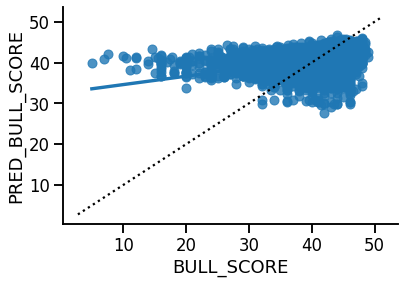

In [ ]:
f = sns.regplot('BULL_SCORE','PRED_BULL_SCORE',
            data=df.loc[df['BULL_SCORE']>0].sample(30000))
plt_max = np.max([f.get_xlim(), f.get_ylim()])
plt_min = np.min([f.get_xlim(), f.get_ylim()])
plt.plot([plt_min,plt_max],[plt_min,plt_max],'k:')
sns.despine()
plt.show()

In [ ]:
df['BULL_ERROR'] = df['PRED_BULL_SCORE'].sub(df['BULL_SCORE'])

In [ ]:
df['BULL_ERROR'].describe()

count    440833.000000
mean          4.209580
std          12.573022
min         -20.464176
25%          -1.566313
50%          -0.092992
75%           2.214877
max          47.158555
Name: BULL_ERROR, dtype: float64

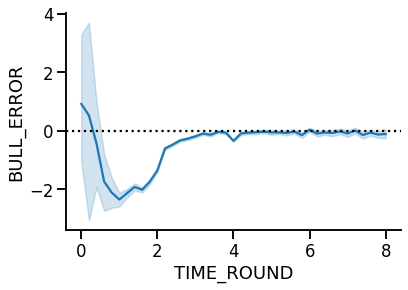

In [ ]:
df['TIME_ROUND'] = ((df['TIME'].mul(5)).round(0)).div(5)
f = sns.lineplot('TIME_ROUND','BULL_ERROR',
            data=df.loc[(df['BULL_SCORE']>0)&
                        (df['TIME'].between(0.01,7.99))])
# plt_max = np.max([f.get_xlim(), f.get_ylim()])
# plt_min = np.min([f.get_xlim(), f.get_ylim()])
# plt.plot([plt_min,plt_max],[plt_min,plt_max],'k:')
plt.axhline(0,c='k',ls=':')
# plt.axhline(-2,c='r',ls='--')
# plt.axhline(2,c='r',ls='--')
sns.despine()
plt.show()

### It is possible to predict the score of a bull given some basic features of a bull  
Using a model based on year, level of competition, time length of a ride, and rider handedness percentage, I can generate a prediction for bull score that is seemingly accurate ($RMSE$: 4, error stabilization at 2s). This will be good for subsequent predictions of rider performance and also when calculating the effects due to the bull.  

## Naive category ID model  
run-of-the-mill GBT model trained on IDs  

In [ ]:
model_feats = ['YEAR','BULL_ID','CONTESTANT_CODE','LEVEL_CODE']
target = 'RIDER_SCORE'

model_data = df.loc[df['TIME']==8, model_feats+[target]]
model_data.head()

,YEAR,BULL_ID,CONTESTANT_CODE,LEVEL_CODE,RIDER_SCORE
7,2003,1,2551,3,42.0
9,2003,2,1952,3,40.0
10,2003,2,5818,3,41.0
12,2003,2,4694,3,39.0
15,2003,2,4240,3,41.0


In [ ]:
_riders = model_data['CONTESTANT_CODE'].drop_duplicates().sample(frac=.2)
test_data = model_data.loc[model_data['CONTESTANT_CODE'].isin(_riders.values)]
train_data = model_data.loc[~model_data.index.isin(test_data.index.values)]
print(f"train data: {train_data.shape}\ntest data: {test_data.shape}")

train data: (88886, 5)
test data: (23211, 5)


In [ ]:
lgbm_train = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE','LEVEL_CODE'], free_raw_data=False)
lgbm_test = lgb.Dataset(test_data.loc[:,model_feats], test_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE','LEVEL_CODE'], free_raw_data=False)

In [ ]:
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,lgbm_train, num_boost_round=2000, valid_sets=lgbm_test,
                  early_stopping_rounds=200, verbose_eval=False)

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


In [ ]:
test_data['pred'] = pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


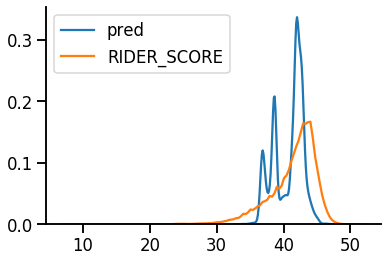

RMSE: 3.077172382509201


In [ ]:
sns.kdeplot(test_data['pred'])
sns.kdeplot(test_data[target])
sns.despine()
plt.show()
print(f"RMSE: {mean_squared_error(test_data[target],test_data['pred'])**0.5}")


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


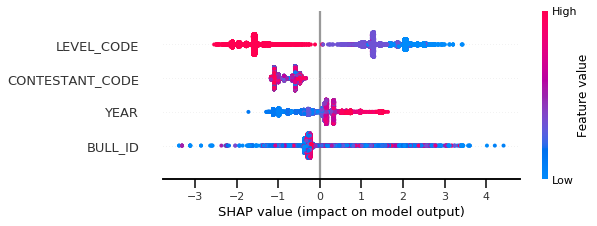

In [ ]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [ ]:
df.loc[:,['RODEO_LEVEL','LEVEL_CODE']].drop_duplicates()

,RODEO_LEVEL,LEVEL_CODE
0,R,3
24700,NFR,2
24853,AB,0
48441,BB,1


## Category ID model  
run-of-the-mill GBT model trained on IDs, with predicted bull score   

In [ ]:
model_feats = ['YEAR','BULL_ID','CONTESTANT_CODE','LEVEL_CODE','PRED_BULL_SCORE']
target = 'RIDER_SCORE'

model_data = df.loc[df['TIME']==8, model_feats+[target]]
model_data.head()

,YEAR,BULL_ID,CONTESTANT_CODE,LEVEL_CODE,PRED_BULL_SCORE,RIDER_SCORE
7,2003,1,2551,3,39.136864,42.0
9,2003,2,1952,3,37.746770,40.0
10,2003,2,5818,3,37.746770,41.0
12,2003,2,4694,3,37.746770,39.0
15,2003,2,4240,3,37.746770,41.0


In [ ]:
# _riders = model_data['CONTESTANT_CODE'].drop_duplicates().sample(frac=.2)
test_data = model_data.loc[model_data['CONTESTANT_CODE'].isin(_riders.values)]
train_data = model_data.loc[~model_data.index.isin(test_data.index.values)]
print(f"train data: {train_data.shape}\ntest data: {test_data.shape}")

train data: (88886, 6)
test data: (23211, 6)


In [ ]:
lgbm_train = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE','LEVEL_CODE'], free_raw_data=False)
lgbm_test = lgb.Dataset(test_data.loc[:,model_feats], test_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE','LEVEL_CODE'], free_raw_data=False)

In [ ]:
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,lgbm_train, num_boost_round=2000, valid_sets=lgbm_test,
                  early_stopping_rounds=200, verbose_eval=False)

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


In [ ]:
test_data['pred'] = pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


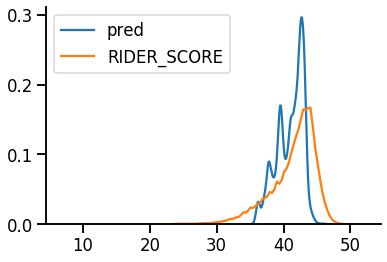

RMSE: 2.9606513780992527


In [ ]:
sns.kdeplot(test_data['pred'])
sns.kdeplot(test_data[target])
sns.despine()
plt.show()
print(f"RMSE: {mean_squared_error(test_data[target],test_data['pred'])**0.5}")


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


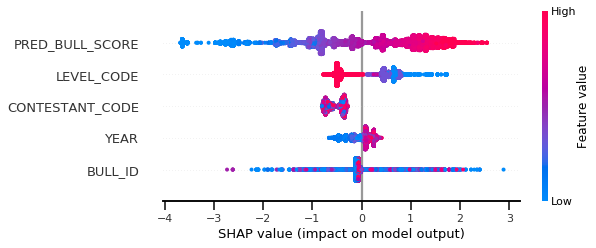

In [ ]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [ ]:
kf = KFold(5)
pred = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  train_data = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE'], free_raw_data=False)
  test_data = model_data.iloc[test_idx]
  p = dict(objective='regression',boosting='gbdt', metric='rmse')
  model = lgb.train(p,train_data, num_boost_round=200, verbose_eval=False)
  pred = pred.append(pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0])


Using categorical_feature in Dataset.


In [ ]:
_model_data = lgb.Dataset(model_data.loc[:,model_feats], model_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE'], free_raw_data=False)
pred_data = df.loc[df['TIME']!=8, model_feats+[target]]
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,_model_data, num_boost_round=200, verbose_eval=False)
df['PRED_RIDER_SCORE'] = pd.DataFrame(model.predict(pred_data.loc[:,model_feats]),index=pred_data.index)[0]
df['PRED_RIDER_SCORE'] = df['PRED_RIDER_SCORE'].fillna(pred)

Using categorical_feature in Dataset.


## Bull Factors
If we treat bulls like parks, can we calculate "bull" factors?  

In [ ]:
bull_factors = (df.loc[df['GO']!='F',['YEAR','RODEO_LEVEL', 'LEVEL_CODE','BULL_ID','BULL_NAME',
                          'TIME','QR','BULL_SCORE','POWER','PRED_BULL_SCORE',
                          'BULL_ERROR','RIDER_SCORE','PRED_RIDER_SCORE']]
                .groupby(['YEAR','RODEO_LEVEL', 'LEVEL_CODE','BULL_ID','BULL_NAME'],as_index=False)
                .mean().merge(df.loc[:,['YEAR','RODEO_LEVEL', 'LEVEL_CODE',
                                        'BULL_ID','BULL_NAME','PRED_RIDER_SCORE']]
                .groupby(['YEAR','RODEO_LEVEL', 'LEVEL_CODE','BULL_ID','BULL_NAME'],as_index=False)
                .count().rename(columns={'PRED_RIDER_SCORE':'COUNT'})))
bull_factors.head()

,YEAR,RODEO_LEVEL,LEVEL_CODE,BULL_ID,BULL_NAME,TIME,QR,BULL_SCORE,POWER,PRED_BULL_SCORE,BULL_ERROR,RIDER_SCORE,PRED_RIDER_SCORE,COUNT
0,1995,BB,1,2886,Wrangler,8.0,1.0,40.0,34.8,41.230761,1.230761,40.5,41.586371,2
1,1995,BB,1,3307,-1,8.0,1.0,42.5,-1.0,42.121506,-0.378494,44.5,42.067058,2
2,1995,BB,1,4132,-1,8.0,1.0,44.0,-1.0,42.121506,-1.878494,46.0,42.294332,1
3,1995,BB,1,5112,-1,8.0,1.0,41.0,-1.0,42.121506,1.121506,43.5,42.566848,2
4,1995,BB,1,5616,-1,8.0,1.0,43.0,-1.0,42.121506,-0.878494,44.0,41.381579,1


count    60.000000
mean     33.083333
std       6.274219
min      26.000000
25%      28.000000
50%      31.000000
75%      37.250000
max      51.000000
Name: COUNT, dtype: float64

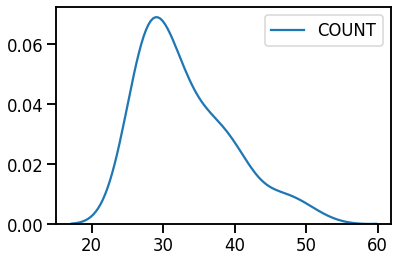

In [ ]:
target = 'PRED_RIDER_SCORE'
df_plt = bull_factors.loc[(bull_factors['YEAR']>=2017)&(bull_factors['RODEO_LEVEL']=='AB'),['BULL_ID','BULL_NAME',target,'COUNT']]
_df_plt = df_plt.loc[:,['BULL_ID','COUNT']].groupby('BULL_ID',as_index=False).sum()
df_plt = df_plt.loc[df_plt['BULL_ID'].isin(_df_plt.loc[_df_plt['COUNT']>25,'BULL_ID'].unique())]
df_plt = df_plt.loc[:,['BULL_ID','BULL_NAME',target]].groupby(['BULL_ID','BULL_NAME'],as_index=False).mean().merge(df_plt.loc[:,['BULL_ID','COUNT']].groupby('BULL_ID',as_index=False).sum())
df_plt[f'z{target}'] = pd.Series(scale(df_plt[target]),index=df_plt.index)
df_plt[f'{target}_pc'] = (df_plt[target].sub(df_plt[target].mean())).div(df_plt[target].mean())
sns.kdeplot(df_plt['COUNT'])
df_plt['COUNT'].describe()

count    60.000000
mean     43.921815
std       0.587374
min      42.953158
25%      43.630923
50%      43.751387
75%      44.028395
max      46.583954
Name: PRED_RIDER_SCORE, dtype: float64

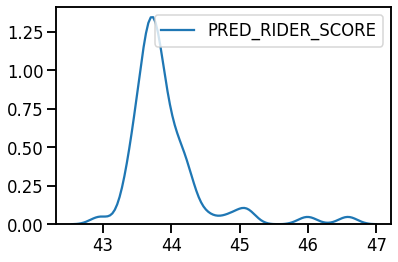

In [ ]:
sns.kdeplot(df_plt[target])
df_plt[target].describe()

count    6.000000e+01
mean    -1.857889e-16
std      1.337317e-02
min     -2.205412e-02
25%     -6.622954e-03
50%     -3.880257e-03
75%      2.426593e-03
max      6.061087e-02
Name: PRED_RIDER_SCORE_pc, dtype: float64

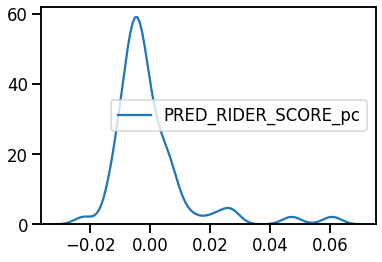

In [ ]:
sns.kdeplot(df_plt[f'{target}_pc'])
df_plt[f'{target}_pc'].describe()

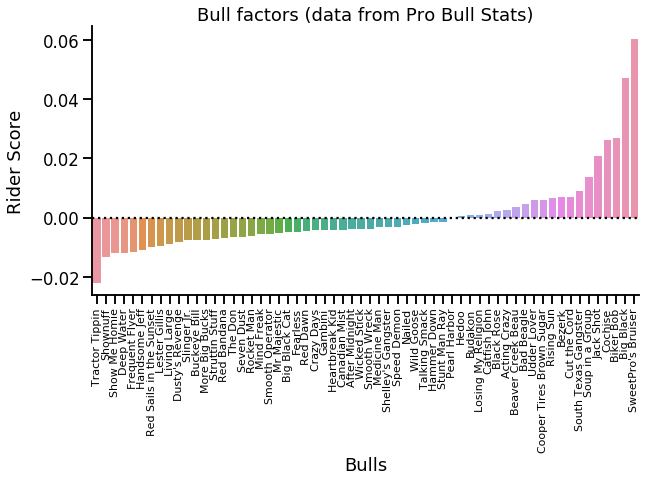

In [ ]:
sns.catplot('BULL_NAME',f'{target}_pc',order=df_plt.sort_values(f'{target}_pc').loc[:,'BULL_NAME'].values,
            data=df_plt,kind='bar')
plt.xticks(rotation=90,fontsize=11)
plt.axhline(0,ls=':',c='k')
plt.xlabel('Bulls')
plt.ylabel('Rider Score')
plt.gcf().set_size_inches(17, plt.gcf().get_size_inches()[1])
plt.title('Bull factors (data from Pro Bull Stats)')
plt.show()

In [ ]:
df_plt['BULL_FACTOR'] = df_plt[f'{target}_pc'].mul(-1).add(1)

In [ ]:
df['BULL_FACTOR'] = ((df[target].sub(df_plt[target].mean())).div(df_plt[target].mean())).mul(-1).add(1)

In [ ]:
df['ADJ_PRED_RIDER_SCORE'] = df['PRED_RIDER_SCORE'].mul(df['BULL_FACTOR'])
df['ADJ_RIDER_SCORE'] = df['RIDER_SCORE'].mul(df['BULL_FACTOR'])

In [ ]:
df_plt = df.loc[df['RODEO_LEVEL']=='AB']
df_plt = df_plt.loc[:,['CONTESTANT','BULL_FACTOR']].groupby('CONTESTANT',as_index=False).mean().merge(df_plt.loc[:,['CONTESTANT','BULL_FACTOR']].groupby('CONTESTANT',as_index=False).count().rename(columns={'BULL_FACTOR':'COUNT'}))
df_plt['BULL_FACTOR_REL'] = df_plt['BULL_FACTOR'].sub(1)

count    148.000000
mean       1.012939
std        0.010324
min        0.987730
25%        1.007659
50%        1.011758
75%        1.018753
max        1.050271
Name: BULL_FACTOR, dtype: float64

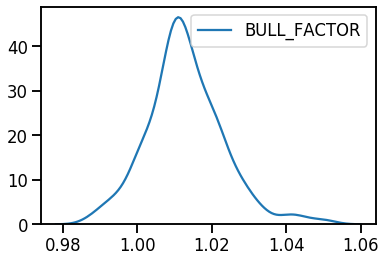

In [ ]:
sns.kdeplot(df_plt.loc[df_plt['COUNT']>=100,'BULL_FACTOR'])
df_plt.loc[df_plt['COUNT']>=100,'BULL_FACTOR'].describe()

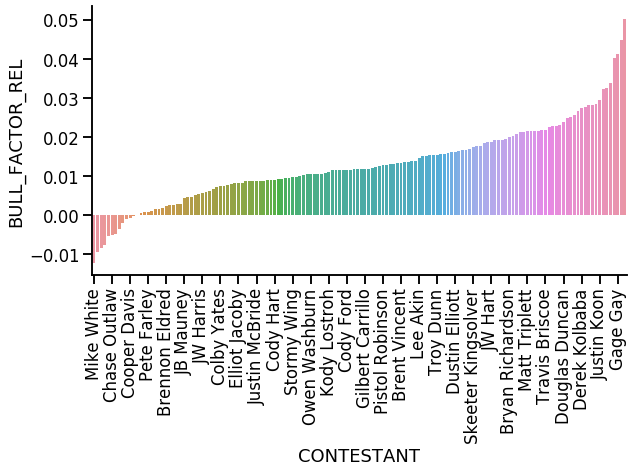

In [ ]:
sns.catplot('CONTESTANT','BULL_FACTOR_REL',
            data=df_plt.loc[df_plt['COUNT']>=100],kind='bar',
            order=df_plt.loc[df_plt['COUNT']>=100].sort_values('BULL_FACTOR_REL').loc[:,'CONTESTANT'])
plt.xticks(rotation=90)
plt.gcf().set_size_inches(17, plt.gcf().get_size_inches()[1])
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(5))
plt.show()

In [ ]:
df_plt.loc[df_plt['CONTESTANT']=='Renato Nunes']

,CONTESTANT,BULL_FACTOR,COUNT,BULL_FACTOR_REL
404,Renato Nunes,1.009489,724,0.009489


In [ ]:
_df_plt.shape

(55, 4)

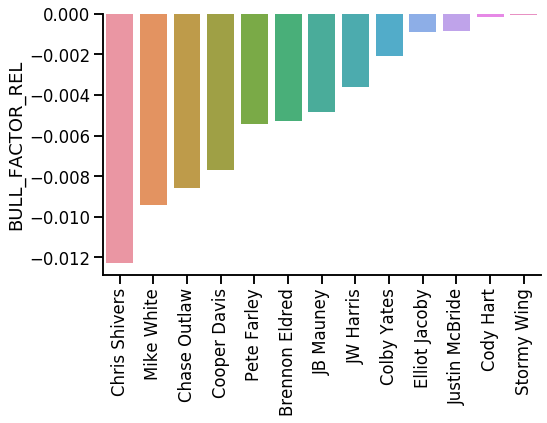

In [ ]:
_df_plt = df_plt.loc[(df_plt['COUNT']>=100)&(df_plt['BULL_FACTOR_REL']<=0)]
sns.catplot('CONTESTANT','BULL_FACTOR_REL',
            data=_df_plt,kind='bar',
            order=_df_plt.sort_values('BULL_FACTOR_REL').loc[:,'CONTESTANT'])
plt.xticks(rotation=90)
plt.xlabel(None)
plt.gcf().set_size_inches(12, plt.gcf().get_size_inches()[1])
plt.show()

In [ ]:
qual_riders = df.loc[:,['CONTESTANT','QR']].groupby('CONTESTANT',as_index=False).count()
qual_riders = qual_riders.loc[qual_riders['QR']>50,'CONTESTANT'].unique()

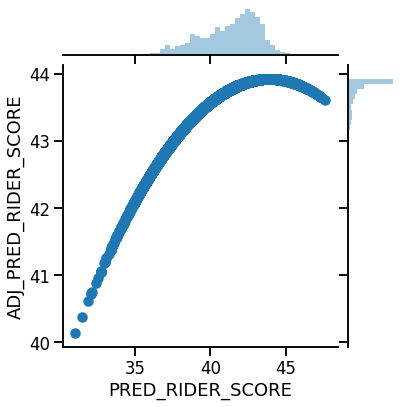

In [ ]:
df_plt = df.loc[(df['CONTESTANT'].isin(qual_riders))&(df['QR']==1)&(df['GO']!='F')]
sns.jointplot('PRED_RIDER_SCORE','ADJ_PRED_RIDER_SCORE',data=df_plt)
plt.show()

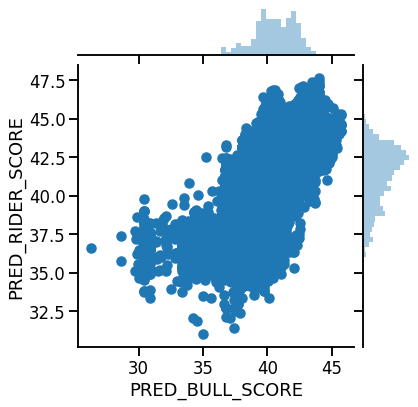

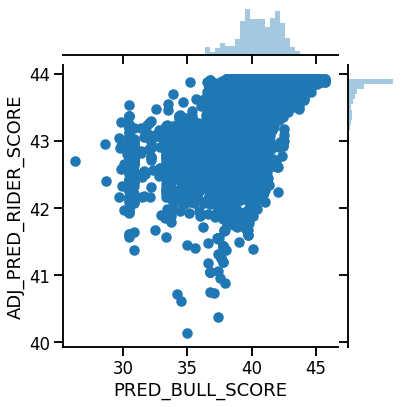

In [ ]:
sns.jointplot('PRED_BULL_SCORE','PRED_RIDER_SCORE',data=df_plt)
plt.show()

sns.jointplot('PRED_BULL_SCORE','ADJ_PRED_RIDER_SCORE',data=df_plt)
plt.show()

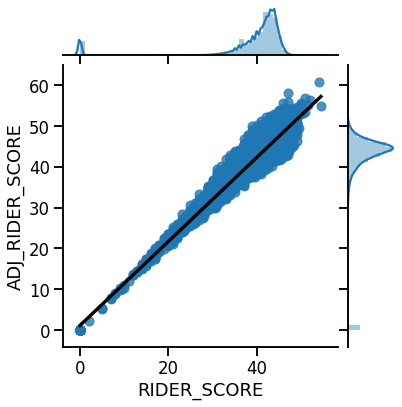

In [ ]:
sns.jointplot('RIDER_SCORE','ADJ_RIDER_SCORE',data=df_plt,kind='reg',joint_kws={'line_kws':{'color':'k'}})
plt.show()

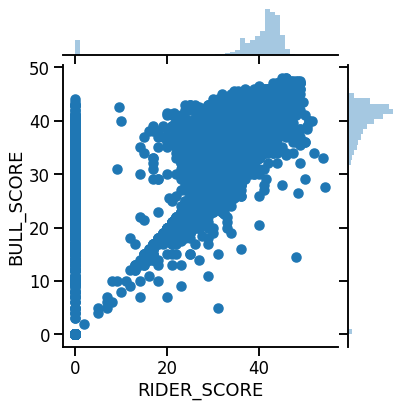

In [ ]:
sns.jointplot('RIDER_SCORE','BULL_SCORE',data=df_plt)
plt.show()

### Bull factors exist!  
Bulls can be similarly treated like ball parks in baseball -- depending on the bull a rider is riding, it's possible the rider scores higher (or lower) simply due to the effects of the bull (a "good" bull should increase your score, a "bad" bull should decrease your score).  

Hypothetically, if we aggregate predicted rider scores by the ID of a bull, we can get a distribution of rider scores, where half of the distribution inflates the scores of the rider and the other half of the distribution deflates the scores of the rider. Assuming a relatively random sample of riders (specific to the highest level of competition), the subsequent aggregate scores for a rider should be due (at least in part) to the effects of the bull.  

I discovered that there is a relatively normal distribution of "bull factors", where some bull inflate their rider's scores while other bulls deflate their rider's scores.

We can take these bull factors and turn them into weights, multiplying through the scores of riders, and describing the bull-neutral score a rider should have received in a bull-neutral setting (think: all bulls are scored the same). We reveal that the vast majority of pro riders are benefitted by the bull they ride while 14 riders (over their careers) were negatively impacted by the bulls they rode.  

Confoundingly, the names of the 14 negatively impacted riders are also some of the best riders to date. It is entirely possible that their riding styles (which are subjectively all very similar) may be a sort of third factor -- judges who score these riders high may subsequently score bulls low, discounting points simply due to how _good_ the rider was. This may not impact the event a rider was in, but over the course of their career the effects of the "bull" (or rather, the judges effect on the bull) a great rider may be impacted negatively.  

Futher research would take into account more factors on either the bull or the judges scoring the events in order to truly determine whether these bull factors are attributed correctly. Also, whether bull factors affect the rider in a multiplicative way or an additive way is also outstanding.

2/4/2020

## Bull feature model  
GBT model trained on rider ID and bull features  

In [ ]:
model_feats = ['YEAR','CONTESTANT_CODE','LEVEL_CODE',
               'VSRPERC', 'VSLPERC',
               'POWER', 'WINPERC']
target = 'RIDER_SCORE'

model_data = df.loc[df['TIME']==8, model_feats+[target]]
model_data.head()

,YEAR,CONTESTANT_CODE,LEVEL_CODE,VSRPERC,VSLPERC,POWER,WINPERC,RIDER_SCORE
7,2003,2551,3,33.33,14.29,54.28,0.077,42.0
9,2003,1952,3,0.00,20.00,51.55,0.071,40.0
10,2003,5818,3,0.00,20.00,51.55,0.071,41.0
12,2003,4694,3,0.00,20.00,51.55,0.071,39.0
15,2003,4240,3,0.00,20.00,51.55,0.071,41.0


In [ ]:
_riders = model_data['CONTESTANT_CODE'].drop_duplicates().sample(frac=.2)
test_data = model_data.loc[model_data['CONTESTANT_CODE'].isin(_riders.values)]
train_data = model_data.loc[~model_data.index.isin(test_data.index.values)]
print(f"train data: {train_data.shape}\ntest data: {test_data.shape}")

train data: (90776, 8)
test data: (21321, 8)


In [ ]:
lgbm_train = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target], categorical_feature=['CONTESTANT_CODE','LEVEL_CODE'], free_raw_data=False)
lgbm_test = lgb.Dataset(test_data.loc[:,model_feats], test_data.loc[:,target], categorical_feature=['CONTESTANT_CODE','LEVEL_CODE'], free_raw_data=False)

In [ ]:
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,lgbm_train, num_boost_round=2000, valid_sets=lgbm_test,
                  early_stopping_rounds=200, verbose_eval=False)

Using categorical_feature in Dataset.
categorical_feature in param dict is overridden.


In [ ]:
test_data['pred'] = pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


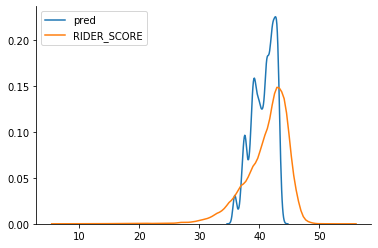

RMSE: 3.204804386665816


In [ ]:
sns.kdeplot(test_data['pred'])
sns.kdeplot(test_data[target])
sns.despine()
plt.show()
print(f"RMSE: {mean_squared_error(test_data[target],test_data['pred'])**0.5}")


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


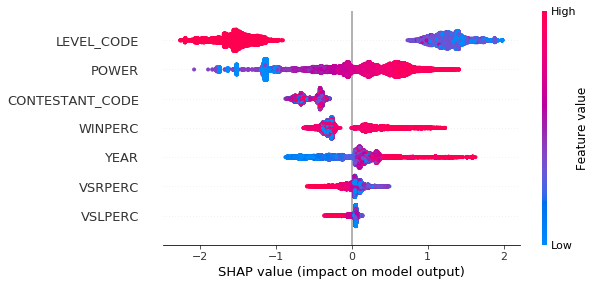

In [ ]:
shap_data = test_data.loc[:,model_feats]
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(shap_data)
shap.summary_plot(shap_values, shap_data)

In [ ]:
kf = KFold(5)
pred = pd.Series()
for train_idx, test_idx in kf.split(model_data):
  train_data = model_data.iloc[train_idx]
  train_data = lgb.Dataset(train_data.loc[:,model_feats], train_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE'], free_raw_data=False)
  test_data = model_data.iloc[test_idx]
  p = dict(objective='regression',boosting='gbdt', metric='rmse')
  model = lgb.train(p,train_data, num_boost_round=200, verbose_eval=False)
  pred = pred.append(pd.DataFrame(model.predict(test_data.loc[:,model_feats]),index=test_data.index)[0])


Using categorical_feature in Dataset.


TypeError: ignored

In [ ]:
_model_data = lgb.Dataset(model_data.loc[:,model_feats], model_data.loc[:,target], categorical_feature=['BULL_ID','CONTESTANT_CODE'], free_raw_data=False)
pred_data = df.loc[df['TIME']!=8, model_feats+[target]]
p = dict(objective='regression',boosting='gbdt', metric='rmse')
model = lgb.train(p,_model_data, num_boost_round=200, verbose_eval=False)
df['PRED_RIDER_SCORE'] = pd.DataFrame(model.predict(pred_data.loc[:,model_feats]),index=pred_data.index)[0]
df['PRED_RIDER_SCORE'] = df['PRED_RIDER_SCORE'].fillna(pred)

In [ ]:
_counts = df['CONTESTANT'].value_counts()
qual_riders = _counts[_counts>=50].index.values
df.loc[df['CONTESTANT'].isin(qual_riders),['CONTESTANT_CODE','CONTESTANT','QR']].groupby(['CONTESTANT_CODE','CONTESTANT'],as_index=False).mean().sort_values('QR',ascending=False).head(10)

In [ ]:
df.loc[(df['QR']==1)&(df['CONTESTANT'].isin(qual_riders)),['CONTESTANT_CODE','CONTESTANT','RIDER_SCORE']].groupby(['CONTESTANT_CODE','CONTESTANT'],as_index=False).mean().sort_values('RIDER_SCORE',ascending=False).head(10)

In [ ]:
print(df.loc[(df['BULL_ID']==29784)&(df['TIME']>3.5)&(df['QR']==0),'TIME'].describe())
print()
print(df.loc[(df['BULL_ID']==29784)&(df['TIME']<=3.5)&(df['QR']==0),'TIME'].describe())

In [ ]:
print(df.loc[(df['BULL_ID']==29784)&(df['TIME']>3.5)&(df['QR']==0),'CONTESTANT'].unique())
print()
print(df.loc[(df['BULL_ID']==29784)&(df['TIME']<=3.5)&(df['QR']==0),'CONTESTANT'].unique())

In [ ]:
df.columns.values

In [ ]:
df_level = df.loc[:,['YEAR','RODEO_LEVEL','QR']].groupby(['YEAR','RODEO_LEVEL'],as_index=False).mean().merge(df.loc[:,['YEAR','RODEO_LEVEL','QR']].groupby(['YEAR','RODEO_LEVEL'],as_index=False).count().rename(columns={'QR':'N_ROWS'}))
df_level = df_level.merge(df.loc[df['QR']==1,['YEAR','RODEO_LEVEL','RIDER_SCORE']].groupby(['YEAR','RODEO_LEVEL'],as_index=False).mean(),how='left').merge(df.loc[:,['YEAR','RODEO_LEVEL','TIME']].groupby(['YEAR','RODEO_LEVEL'],as_index=False).mean().rename(columns={'TIME':'TIME_UNCONDITIONAL'}).merge(df.loc[df['QR']==0,['YEAR','RODEO_LEVEL','TIME']].groupby(['YEAR','RODEO_LEVEL'],as_index=False).mean().rename(columns={'TIME':'TIME_CONDITIONAL'}),how='left'),how='left')
df_level = df_level.merge(df.loc[:,['YEAR','RODEO_LEVEL','BULL_SCORE']].groupby(['YEAR','RODEO_LEVEL'],as_index=False).mean(),how='left')

In [ ]:
df_level.head()

In [ ]:
sns.lineplot('YEAR','N_ROWS',data=df_level,hue='RODEO_LEVEL')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()
plt.show()

df_level.describe()

In [ ]:
train_data = df_level.loc[df_level['YEAR']<2018].dropna()
test_data = df_level.loc[df_level['YEAR']>=2018].dropna()

In [ ]:
model_feats = ['N_ROWS', 'RIDER_SCORE', 'TIME_UNCONDITIONAL',
               'TIME_CONDITIONAL', 'BULL_SCORE']
target = 'QR'
agg_linear_weights = LinearRegression()
agg_linear_weights.fit(train_data.loc[:,model_feats],train_data.loc[:,target])

In [ ]:
test_data[f'{target}_pred'] = pd.Series(agg_linear_weights.predict(test_data.loc[:,model_feats]),index=test_data.index)

In [ ]:
test_data.loc[:,['YEAR','RODEO_LEVEL',target, f"{target}_pred"]]

In [ ]:
pd.DataFrame(['intercept',agg_linear_weights.intercept_]).T.append(pd.DataFrame([model_feats,agg_linear_weights.coef_]).T,ignore_index=True)

In [ ]:
explainer = shap.LinearExplainer(agg_linear_weights, train_data.loc[:,model_feats])
shap_values = explainer.shap_values(train_data.loc[:,model_feats])
shap.summary_plot(shap_values, train_data.loc[:,model_feats], feature_names=model_feats)

In [ ]:
model_feats = ['N_ROWS', 'RIDER_SCORE', 'TIME_UNCONDITIONAL',
               'TIME_CONDITIONAL', 'BULL_SCORE']
target = 'QR'

level_models = {}
for level in df_level['RODEO_LEVEL'].unique():
  train_data = df_level.loc[(df_level['RODEO_LEVEL']==level)&
                            (df_level['YEAR']<2018)].dropna()
  _agg_linear_weights = LinearRegression()
  _agg_linear_weights.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
  level_models[level] = _agg_linear_weights

In [ ]:
df_weights = pd.DataFrame()
for k in level_models.keys():
  _df = pd.DataFrame([model_feats,level_models[k].coef_],index=['feats','coef']).T
  _df['level'] = k
  df_weights = df_weights.append(_df,ignore_index=True)

In [ ]:
sns.catplot('feats','coef',data=df_weights,hue='level',
            hue_order=['R','BB','AB','NFR'],kind='bar')
plt.xticks(rotation=90)
plt.axhline(0,c='k',ls=':',lw=1)
plt.title('linear weights, by level')
plt.show()

In [ ]:
df_mle = df.loc[:,['RODEO_LEVEL','QR']].groupby('RODEO_LEVEL', as_index=False).mean()
ab_val = df_mle.loc[df_mle['RODEO_LEVEL']=='AB','QR'].values[0]
df_mle['QR_ADJ'] = df_mle['QR'].sub(ab_val)
df_mle

In [ ]:
df_weights

In [ ]:
df_weights2

In [ ]:
df_level = df_level.merge(df_mle.loc[:,['RODEO_LEVEL','QR_ADJ']])
df_level['QR_MLE'] = df_level['QR'].add(df_level['QR_ADJ'])
target = 'QR_MLE'
test_data = df_level.loc[df_level['YEAR']>=2018].dropna()

level_models = {}
for level in df_level['RODEO_LEVEL'].unique():
  train_data = df_level.loc[(df_level['RODEO_LEVEL']==level)&
                            (df_level['YEAR']<2018)].dropna()
  _agg_linear_weights = LinearRegression()
  _agg_linear_weights.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
  level_models[level] = _agg_linear_weights

df_weights = pd.DataFrame()
for k in level_models.keys():
  _df = pd.DataFrame([model_feats,level_models[k].coef_],index=['feats','coef']).T
  _df['level'] = k
  df_weights = df_weights.append(_df,ignore_index=True)

sns.catplot('feats','coef',data=df_weights,hue='level',
            hue_order=['R','BB','AB','NFR'],kind='bar')
plt.xticks(rotation=90)
plt.axhline(0,c='k',ls=':',lw=1)
plt.title('linear weights, by level')
plt.show()

# major league equivalency?  
This didn't work! wtf me?  
